In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.dates import DateFormatter

from load_wastewater_data import load_systems_data

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [11]:
plot_path = f"../plots/wastewater_model/normalization_strategies/flow_rates"
os.makedirs(os.path.join(plot_path), exist_ok=True)
# file_name_prefix = f"{substance}_{rain_scenario}_{degradation_setting}"

In [12]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"

resolution = "3_min_resolution" 
rain_scenario = "MittelstarkerRegen" # one of Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_dynamics", "constant_decay_dynamics"

In [13]:
# Load Data

# for flow normalization
df_KeinRegen = load_systems_data(experiment_series, resolution, "KeinRegen", degradation_setting, file_type="concentrations") 
df_KeinRegen_flow_rates = load_systems_data(experiment_series, resolution, "KeinRegen", degradation_setting, file_type="flow_rates")

# measurements
df_Rain = load_systems_data(experiment_series, resolution, rain_scenario, degradation_setting, file_type="concentrations") 
df_Rain_flow_rates = load_systems_data(experiment_series, resolution, rain_scenario, degradation_setting, file_type="flow_rates") 

### Normalisation with flow rates

copies/l normalized = (current flow rate) / (median flow rate) * (copies/l of RNA)

source: https://www.umweltbundesamt.de/sites/default/files/medien/1/dokumente/amelag-leitfaden-4.pdf

median flow rate represents the estimate of "Trockenwetterzufluss", but we actually now the Trockenwetterzufluss, so we can take the mean values of these...

The median is calculated per sampling point and memilio id based on KeinRegen scenario values

In [14]:
#subselect specific sampling point
sampling_point = "16"

df_flow_rates = df_Rain_flow_rates.loc[df_Rain_flow_rates.sampling_point==sampling_point, :].copy()
df_flow_rates_no_rain = df_KeinRegen_flow_rates.loc[df_KeinRegen_flow_rates.sampling_point==sampling_point, :].copy()

df_concentration = df_Rain.loc[df_Rain.sampling_point==sampling_point, :].copy()
df_concentration_no_rain = df_KeinRegen.loc[df_KeinRegen.sampling_point==sampling_point, :].copy()

In [15]:
# aggregate flow rates data to time interval for which we have concentration data (NOTE: you might have to change this for future settings)
freq = "3min"

df_flow_rates["time"] = pd.Timestamp("2024-01-01") + pd.to_timedelta(df_flow_rates["minutes"], unit='min')
df_flow_rates_no_rain["time"] = pd.Timestamp("2024-01-01") + pd.to_timedelta(df_flow_rates_no_rain["minutes"], unit='min')

df_flow_rates = df_flow_rates.set_index("time").groupby("memilio_id").resample(freq, include_groups=False).ffill().reset_index()
df_flow_rates_no_rain = df_flow_rates_no_rain.set_index("time").groupby("memilio_id").resample(freq, include_groups=False).ffill().reset_index()

In [37]:
df_concentration.minutes.sort_values().unique()

array([    3,     6,     9, ..., 20157, 20159, 20160])

In [10]:
df_flow_rates.head()

,memilio_id,time,minutes,l/s,sampling_point,time_in_days
0,1,2024-01-01 00:06:00,6,0.00000,16,0.004167
1,1,2024-01-01 00:09:00,9,3.37572,16,0.006250
2,1,2024-01-01 00:12:00,12,74.41000,16,0.008333
3,1,2024-01-01 00:15:00,15,359.27000,16,0.010417
4,1,2024-01-01 00:18:00,18,811.33000,16,0.012500


#### Basic plots to get a feeling for the data

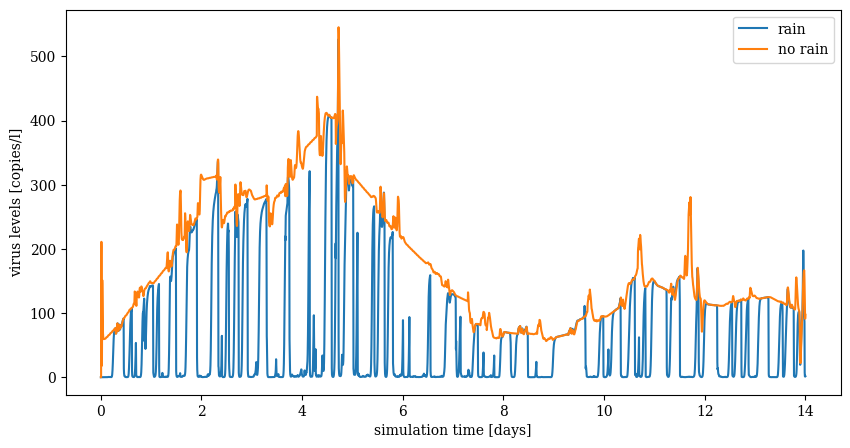

In [11]:
def compare_measurements_of_rain_scenarios(df_concentration, df_concentration_no_rain, memilio_id):
    """
    Create a plot with two curves, one for the concentration of the virus in the rain scenario and one for the concentration in the no rain scenario.
    """
    df_concentration_sub = df_concentration.loc[df_concentration.memilio_id==memilio_id, :].copy()
    df_flow_rates_sub = df_flow_rates.loc[df_flow_rates.memilio_id==memilio_id, :].copy()
    df_flow_rates_no_rain_sub = df_flow_rates_no_rain.loc[df_flow_rates_no_rain.memilio_id==memilio_id, :].copy()
    df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==memilio_id, :].copy()

    df_concentration_sub.sort_values("time_in_days", inplace=True)
    df_flow_rates_sub.sort_values("time_in_days", inplace=True)
    df_flow_rates_no_rain_sub.sort_values("time_in_days", inplace=True)
    df_concentration_no_rain_sub.sort_values("time_in_days", inplace=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(df_concentration_sub.time_in_days, df_concentration_sub["COVID_copies/l"], label="rain")
    plt.plot(df_concentration_no_rain_sub.time_in_days, df_concentration_no_rain_sub["COVID_copies/l"], label="no rain")
    ax.set_xlabel(f"simulation time [days]") # , fontsize=15
    ax.set_ylabel(f"virus levels [copies/l]") # , fontsize=15
    plt.legend()
    plt.close()
    return fig

compare_measurements_of_rain_scenarios(df_concentration, df_concentration_no_rain, 1)

In [38]:
memilio_id = 2

inf
-1389.49259287984


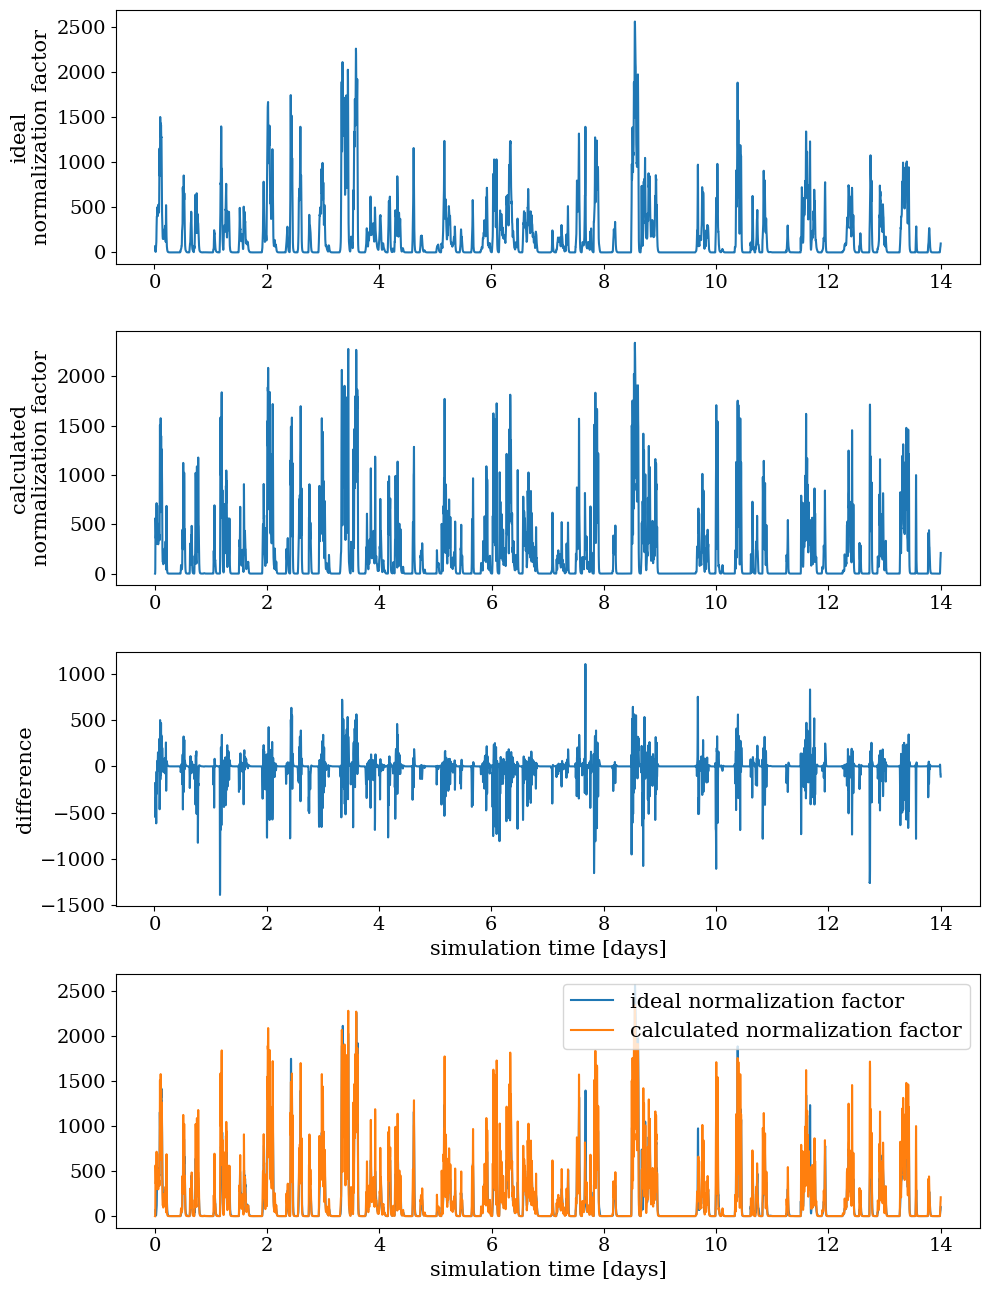

In [13]:
df_concentration_sub = df_concentration.loc[df_concentration.memilio_id==memilio_id, :].copy()
df_flow_rates_sub = df_flow_rates.loc[df_flow_rates.memilio_id==memilio_id, :].copy()
df_flow_rates_no_rain_sub = df_flow_rates_no_rain.loc[df_flow_rates_no_rain.memilio_id==memilio_id, :].copy()
df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==memilio_id, :].copy()

"""
t_max = 2.9
df_concentration_sub = df_concentration.loc[df_concentration.time_in_days<=t_max, :].copy()
df_flow_rates_sub = df_flow_rates.loc[df_flow_rates.time_in_days<=t_max, :].copy()
df_flow_rates_no_rain_sub = df_flow_rates_no_rain.loc[df_flow_rates_no_rain.time_in_days<=t_max, :].copy()
df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.time_in_days<=t_max, :].copy()
"""

df_concentration_sub.sort_values("time_in_days", inplace=True)
df_flow_rates_sub.sort_values("time_in_days", inplace=True)
df_flow_rates_no_rain_sub.sort_values("time_in_days", inplace=True)
df_concentration_no_rain_sub.sort_values("time_in_days", inplace=True)

df_concentration_sub["ideal_normalization"] = df_concentration_no_rain_sub["COVID_copies/l"]/ df_concentration_sub["COVID_copies/l"]
df_flow_rates_sub["true_normalization"] = df_flow_rates_sub["l/s"] /  np.mean(df_flow_rates_no_rain_sub["l/s"])

fig, axs = plt.subplots(nrows=4, figsize=(10, 13), sharey=False, sharex=False)
axs[0].plot(df_concentration_sub.time_in_days, df_concentration_sub["ideal_normalization"], label="ideal normalization factor")
axs[0].set_ylabel(f"ideal\nnormalization factor", fontsize=15)

axs[1].plot(df_flow_rates_sub.time_in_days, df_flow_rates_sub["true_normalization"], label="true normalization factor")
axs[1].set_ylabel(f"calculated\nnormalization factor", fontsize=15)


df_combined = pd.merge(df_concentration_sub, df_flow_rates_sub, on="time_in_days")
axs[2].plot(df_combined.time_in_days, df_combined["ideal_normalization"]-df_combined["true_normalization"], label="difference")
axs[2].set_ylabel(f"difference", fontsize=15)
axs[2].set_xlabel(f"simulation time [days]", fontsize=15) # 

axs[3].plot(df_concentration_sub.time_in_days, df_concentration_sub["ideal_normalization"], label="ideal normalization factor")
axs[3].plot(df_flow_rates_sub.time_in_days, df_flow_rates_sub["true_normalization"], label="calculated normalization factor")
axs[3].set_xlabel(f"simulation time [days]", fontsize=15) # , fontsize=15
axs[3].legend(fontsize=15)

for i, ax in enumerate(axs):
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)


plt.tight_layout()

print((df_combined["ideal_normalization"]-df_combined["true_normalization"]).max())
print((df_combined["ideal_normalization"]-df_combined["true_normalization"]).min())

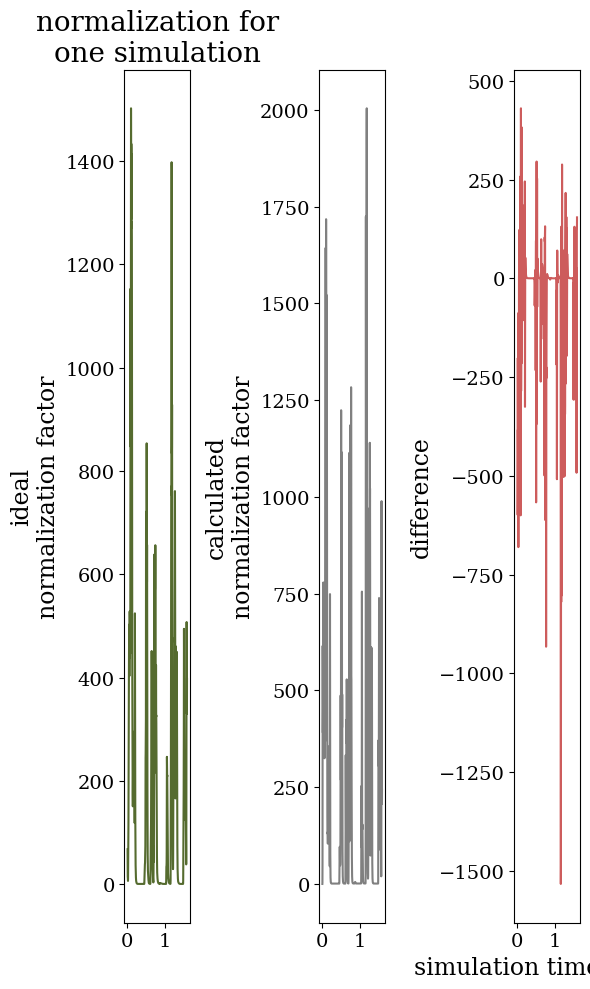

: 

In [16]:
df_concentration_sub = df_concentration.loc[df_concentration.memilio_id==memilio_id, :].copy()
df_flow_rates_sub = df_flow_rates.loc[df_flow_rates.memilio_id==memilio_id, :].copy()
df_flow_rates_no_rain_sub = df_flow_rates_no_rain.loc[df_flow_rates_no_rain.memilio_id==memilio_id, :].copy()
df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==memilio_id, :].copy()

t_max = 1.6
df_concentration_sub = df_concentration_sub.loc[df_concentration_sub.time_in_days<=t_max, :]
df_flow_rates_sub = df_flow_rates_sub.loc[df_flow_rates_sub.time_in_days<=t_max, :]
df_flow_rates_no_rain_sub = df_flow_rates_no_rain_sub.loc[df_flow_rates_no_rain_sub.time_in_days<=t_max, :]
df_concentration_no_rain_sub = df_concentration_no_rain_sub.loc[df_concentration_no_rain_sub.time_in_days<=t_max, :]


df_concentration_sub.sort_values("time_in_days", inplace=True)
df_flow_rates_sub.sort_values("time_in_days", inplace=True)
df_flow_rates_no_rain_sub.sort_values("time_in_days", inplace=True)
df_concentration_no_rain_sub.sort_values("time_in_days", inplace=True)

df_concentration_sub["ideal_normalization"] = df_concentration_no_rain_sub["COVID_copies/l"]/ df_concentration_sub["COVID_copies/l"]
df_flow_rates_sub["true_normalization"] = df_flow_rates_sub["l/s"] /  np.mean(df_flow_rates_no_rain_sub["l/s"])

fig, axs = plt.subplots(ncols=3, figsize=(6, 10), sharey=False, sharex=True)
axs[0].plot(df_concentration_sub.time_in_days, df_concentration_sub["ideal_normalization"], label="ideal normalization factor", c="darkolivegreen")
axs[0].set_ylabel(f"ideal\nnormalization factor", fontsize=17)
axs[0].set_title("normalization for\none simulation", fontsize = 20)

axs[1].plot(df_flow_rates_sub.time_in_days, df_flow_rates_sub["true_normalization"], label="true normalization factor", c="grey")
axs[1].set_ylabel(f"calculated\nnormalization factor", fontsize=17)


df_combined = pd.merge(df_concentration_sub, df_flow_rates_sub, on="time_in_days")
axs[2].plot(df_combined.time_in_days, df_combined["ideal_normalization"]-df_combined["true_normalization"], label="difference", c="indianred")
axs[2].set_ylabel(f"difference", fontsize=17)
axs[2].set_xlabel(f"simulation time [days]", fontsize=17) # 

#axs[3].plot(df_concentration_sub.time_in_days, df_concentration_sub["ideal_normalization"], label="ideal normalization factor")
#axs[3].plot(df_flow_rates_sub.time_in_days, df_flow_rates_sub["true_normalization"], label="calculated normalization factor")
#axs[3].set_xlabel(f"simulation time [days]", fontsize=15) # , fontsize=15
#axs[3].legend(fontsize=14)

for i, ax in enumerate(axs):
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)


plt.tight_layout()

fig.savefig(os.path.join(plot_path, f"normalization_factor_comparison_{rain_scenario}_{degradation_setting}_station_{sampling_point}_simulation_{memilio_id}.png"), dpi=300)

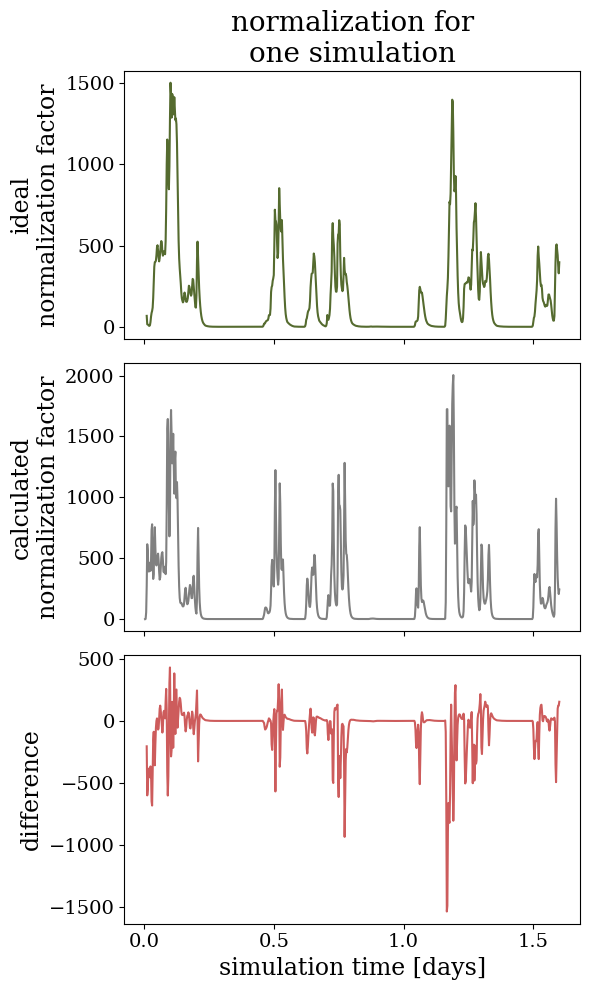

In [46]:
df_concentration_sub = df_concentration.loc[df_concentration.memilio_id==memilio_id, :].copy()
df_flow_rates_sub = df_flow_rates.loc[df_flow_rates.memilio_id==memilio_id, :].copy()
df_flow_rates_no_rain_sub = df_flow_rates_no_rain.loc[df_flow_rates_no_rain.memilio_id==memilio_id, :].copy()
df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==memilio_id, :].copy()

t_max = 1.6
df_concentration_sub = df_concentration_sub.loc[df_concentration_sub.time_in_days<=t_max, :]
df_flow_rates_sub = df_flow_rates_sub.loc[df_flow_rates_sub.time_in_days<=t_max, :]
df_flow_rates_no_rain_sub = df_flow_rates_no_rain_sub.loc[df_flow_rates_no_rain_sub.time_in_days<=t_max, :]
df_concentration_no_rain_sub = df_concentration_no_rain_sub.loc[df_concentration_no_rain_sub.time_in_days<=t_max, :]


df_concentration_sub.sort_values("time_in_days", inplace=True)
df_flow_rates_sub.sort_values("time_in_days", inplace=True)
df_flow_rates_no_rain_sub.sort_values("time_in_days", inplace=True)
df_concentration_no_rain_sub.sort_values("time_in_days", inplace=True)

df_concentration_sub["ideal_normalization"] = df_concentration_no_rain_sub["COVID_copies/l"]/ df_concentration_sub["COVID_copies/l"]
df_flow_rates_sub["true_normalization"] = df_flow_rates_sub["l/s"] /  np.mean(df_flow_rates_no_rain_sub["l/s"])

fig, axs = plt.subplots(nrows=3, figsize=(6, 10), sharey=False, sharex=True)
axs[0].plot(df_concentration_sub.time_in_days, df_concentration_sub["ideal_normalization"], label="ideal normalization factor", c="darkolivegreen")
axs[0].set_ylabel(f"ideal\nnormalization factor", fontsize=17)
axs[0].set_title("normalization for\none simulation", fontsize = 20)

axs[1].plot(df_flow_rates_sub.time_in_days, df_flow_rates_sub["true_normalization"], label="true normalization factor", c="grey")
axs[1].set_ylabel(f"calculated\nnormalization factor", fontsize=17)


df_combined = pd.merge(df_concentration_sub, df_flow_rates_sub, on="time_in_days")
axs[2].plot(df_combined.time_in_days, df_combined["ideal_normalization"]-df_combined["true_normalization"], label="difference", c="indianred")
axs[2].set_ylabel(f"difference", fontsize=17)
axs[2].set_xlabel(f"simulation time [days]", fontsize=17) # 

#axs[3].plot(df_concentration_sub.time_in_days, df_concentration_sub["ideal_normalization"], label="ideal normalization factor")
#axs[3].plot(df_flow_rates_sub.time_in_days, df_flow_rates_sub["true_normalization"], label="calculated normalization factor")
#axs[3].set_xlabel(f"simulation time [days]", fontsize=15) # , fontsize=15
#axs[3].legend(fontsize=14)

for i, ax in enumerate(axs):
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)


plt.tight_layout()

fig.savefig(os.path.join(plot_path, f"normalization_factor_comparison_{rain_scenario}_{degradation_setting}_station_{sampling_point}_simulation_{memilio_id}.png"), dpi=300)

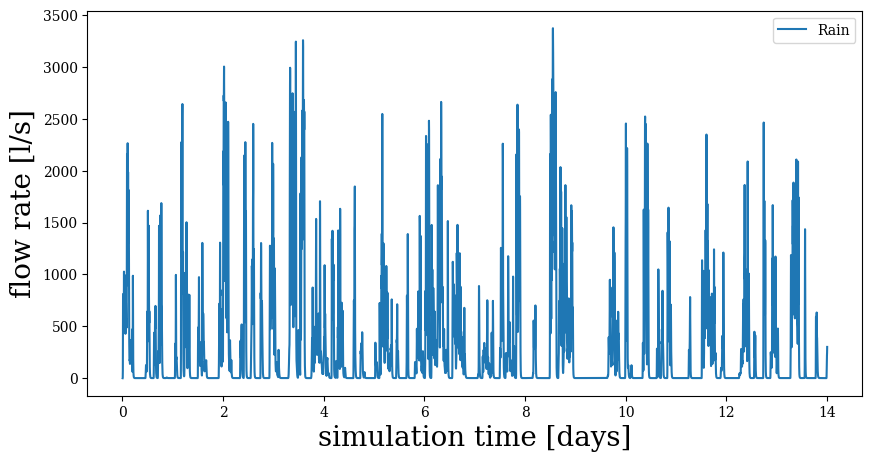

In [47]:
def visualize_flow_rates(df_flow_rates, simulation_id):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(df_flow_rates.loc[df_flow_rates.memilio_id==simulation_id,:], x="time_in_days", y="l/s", label="Rain", ax=ax)
    ax.set_xlabel(f"simulation time [days]", fontsize=20) # , fontsize=15
    ax.set_ylabel(f"flow rate [l/s]", fontsize=20) # , fontsize=15
    # plt.ylim(0,0.5)
    return fig

fig = visualize_flow_rates(df_flow_rates, 1)

#### Aggregation and normalization of data

In [51]:
# aggregate flow rates data to time interval for which we have concentration data (NOTE: you might have to change this for future settings)
freq = "3min"

#df_flow_rates = df_flow_rates.set_index("time").groupby("memilio_id").resample(freq)["l/s"].mean().reset_index()
#df_flow_rates_no_rain = df_flow_rates_no_rain.set_index("time").groupby("memilio_id").resample(freq)["l/s"].mean().reset_index()
# aggregation of concentration data is not necessary
#df_concentration = df_concentration.set_index("time").groupby("memilio_id").resample(freq)["copies/l"].mean().reset_index()
#df_concentration_no_rain = df_concentration_no_rain.set_index("time").groupby("memilio_id").resample(freq)["copies/l"].mean().reset_index()


# potentially play around with rolling means to see whether this improves the normalization.
# in my experience, it does not
"""
rolling_window = "1.5h"
# rolling mean
df_flow_rates = df_flow_rates.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()
df_flow_rates_no_rain = df_flow_rates_no_rain.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()
"""
# possibility to use rolling means for concentration data
#df_concentration = df_concentration.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()
#df_concentration_no_rain = df_concentration_no_rain.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()

'\nrolling_window = "1.5h"\n# rolling mean\ndf_flow_rates = df_flow_rates.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()\ndf_flow_rates_no_rain = df_flow_rates_no_rain.set_index("time").groupby("memilio_id").rolling(pd.Timedelta(rolling_window)).mean().reset_index()\n'

In [7]:
# normalize w.r.t. flow rates
mean_values = df_flow_rates_no_rain.groupby(["memilio_id"])["l/s"].mean().reset_index().rename(columns={"l/s": "mean_l/s"})
df_flow_rates = pd.merge(df_flow_rates, mean_values, on=["memilio_id"], how="left")
normalization_factors = df_flow_rates.loc[:,["time_in_days", "memilio_id"]].copy()
normalization_factors["flow_normalization_factor"] = df_flow_rates["l/s"]/df_flow_rates["mean_l/s"]

df_concentration = pd.merge(df_concentration.loc[:,["time_in_days", "memilio_id", "COVID_copies/l"]], normalization_factors, on=["memilio_id", "time_in_days"], how="inner")
df_concentration["flow_normalized_copies/l"] = df_concentration["COVID_copies/l"]*df_concentration["flow_normalization_factor"]
df_concentration.sort_values("time_in_days", inplace=True)

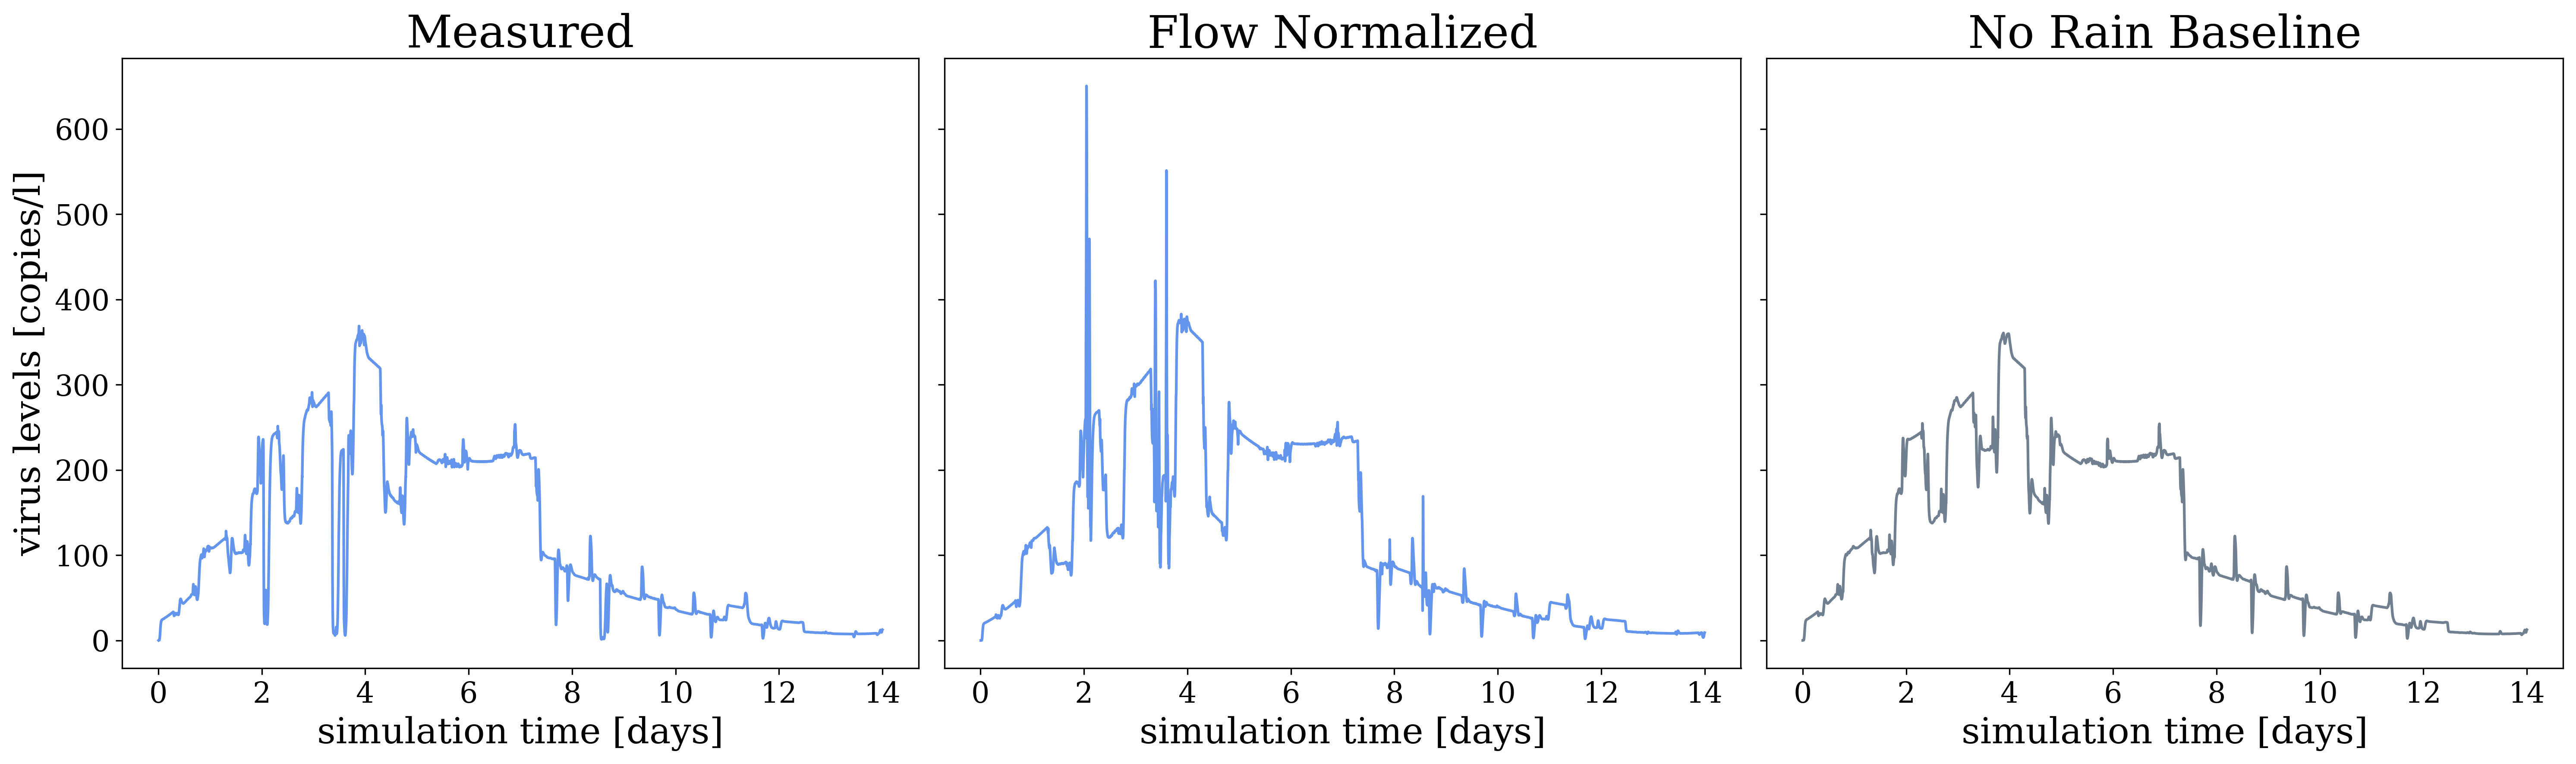

In [8]:
memilio_id = 2

df_concentration_sub = df_concentration.loc[df_concentration.memilio_id==memilio_id, :].copy()
df_concentration_no_rain_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==memilio_id, :].copy()

fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(20, 6), dpi=300)

if rain_scenario == "Nieselregen":
    c_rain = "cornflowerblue"
else:
    c_rain = "navy"

sns.lineplot(df_concentration_sub, x="time_in_days", y="COVID_copies/l", ax=axs[0], c=c_rain)
axs[0].set_title("Measured", fontsize=25)
axs[0].set_ylabel("virus levels [copies/l]", fontsize=20)
sns.lineplot(df_concentration_sub, x="time_in_days", y="flow_normalized_copies/l", ax=axs[1], c=c_rain)
axs[1].set_ylabel("normalized virus levels [copies/l]", fontsize=20)
axs[1].set_title("Flow Normalized", fontsize=25)    
sns.lineplot(df_concentration_no_rain_sub, x="time_in_days", y="COVID_copies/l", ax=axs[2], c="slategray")
axs[2].set_title("No Rain Baseline", fontsize=25)
axs[2].set_ylabel("virus levels [copies/l]", fontsize=20)

for i in range(3):
    axs[i].set_xlabel(f"simulation time [days]", fontsize=20) # , fontsize=15
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].tick_params(axis='y', labelsize=16)

fig.tight_layout()
fig.savefig(os.path.join(plot_path, f"overview_{resolution}_{rain_scenario}_{degradation_setting}_station_{sampling_point}_simulation_{memilio_id}.png"))

#### Visualization of Normalization

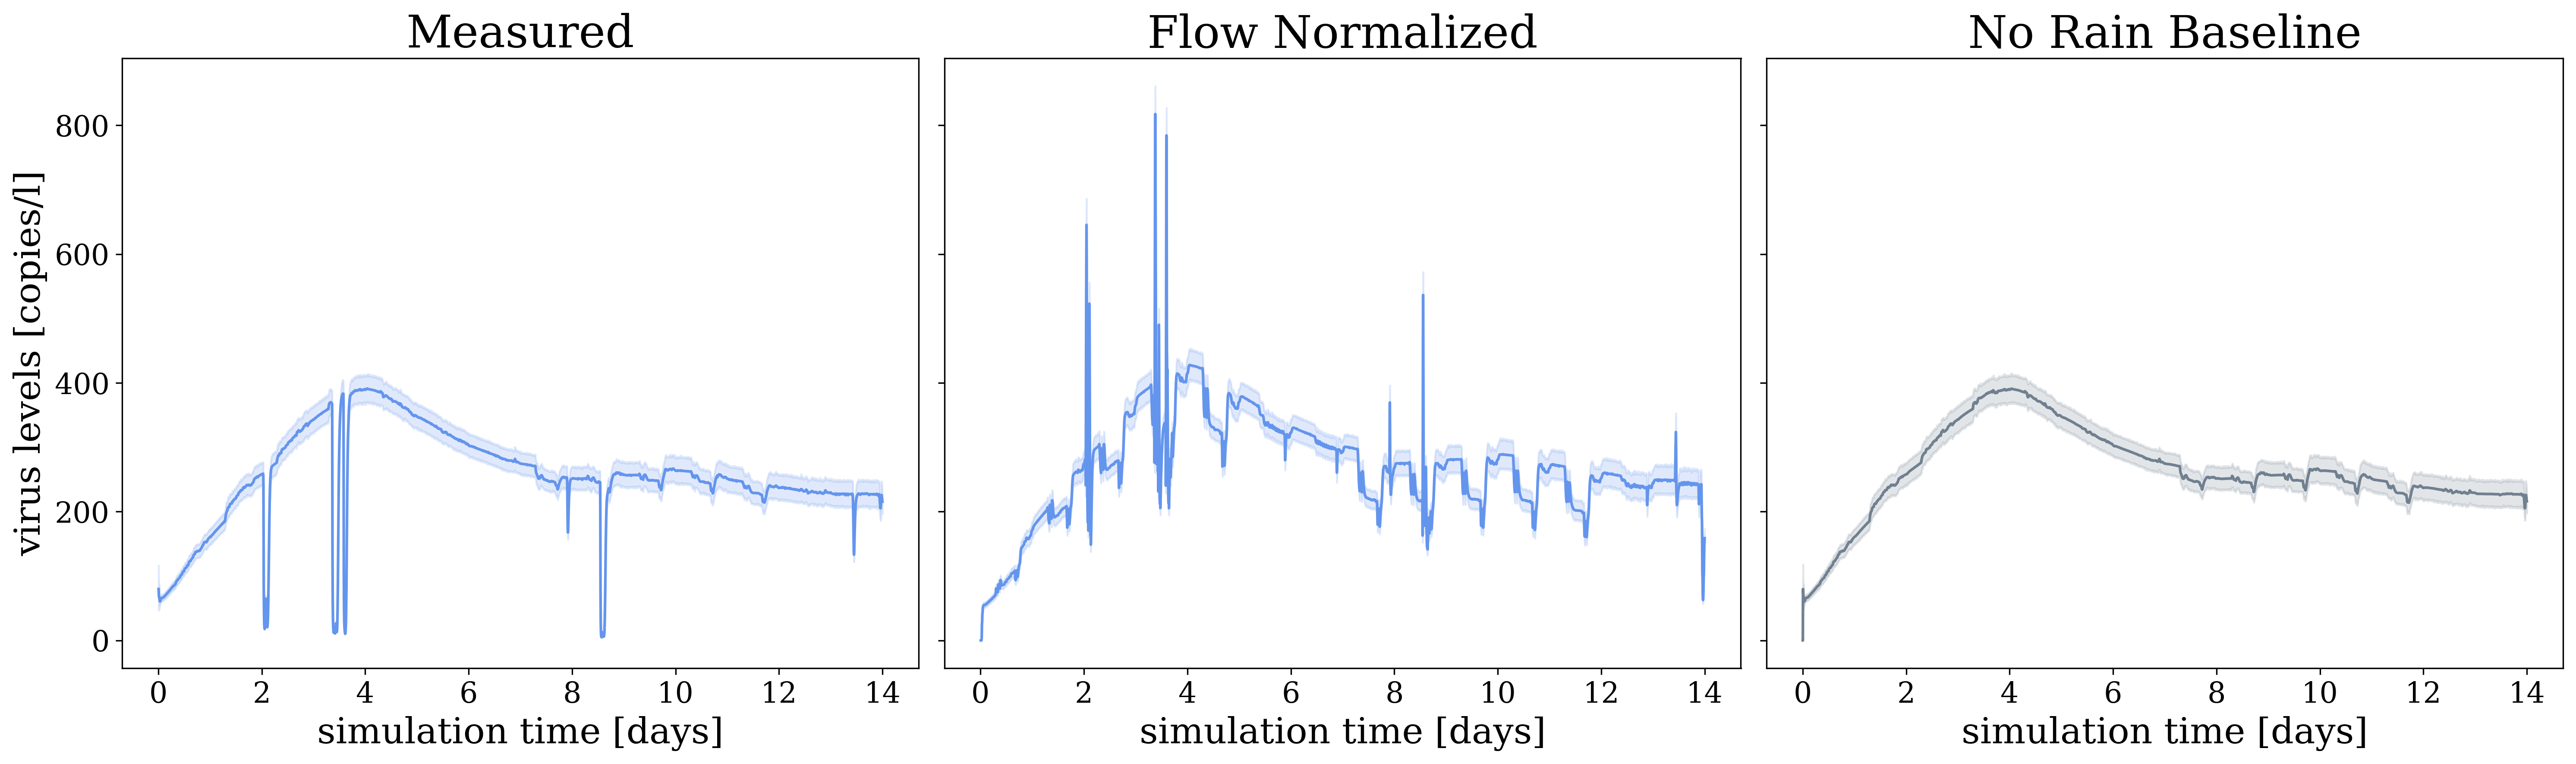

In [9]:
fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(20, 6), dpi=300)

if rain_scenario == "Nieselregen":
    c_rain = "cornflowerblue"
else:
    c_rain = "navy"

sns.lineplot(df_concentration, x="time_in_days", y="COVID_copies/l", ax=axs[0], c=c_rain)
axs[0].set_title("Measured", fontsize=25)
axs[0].set_ylabel("virus levels [copies/l]", fontsize=20)
sns.lineplot(df_concentration, x="time_in_days", y="flow_normalized_copies/l", ax=axs[1], c=c_rain)
axs[1].set_ylabel("normalized virus levels [copies/l]", fontsize=20)
axs[1].set_title("Flow Normalized", fontsize=25)    
sns.lineplot(df_concentration_no_rain, x="time_in_days", y="COVID_copies/l", ax=axs[2], c="slategray")
axs[2].set_title("No Rain Baseline", fontsize=25)
axs[2].set_ylabel("virus levels [copies/l]", fontsize=20)

for i in range(3):
    axs[i].set_xlabel(f"simulation time [days]", fontsize=20) # , fontsize=15
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].tick_params(axis='y', labelsize=16)

fig.tight_layout()
fig.savefig(os.path.join(plot_path, f"overview_{resolution}_{rain_scenario}_{degradation_setting}_{sampling_point}.png"))

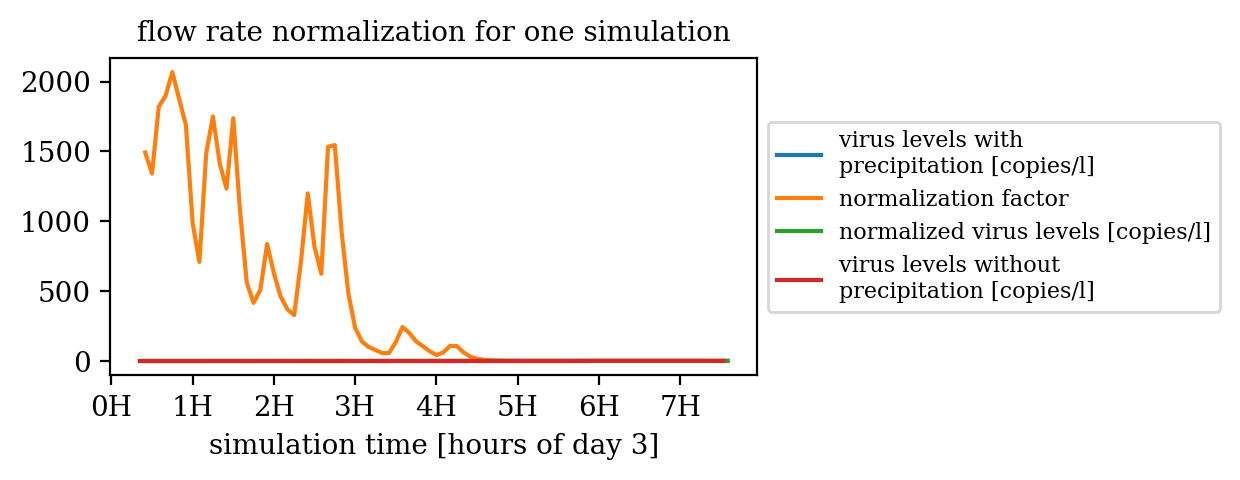

In [161]:
# old additional plot
"""
simulation_id = 5

df_concentration['minutes'] = (df_concentration['time'] - df_concentration['time'].min()).dt.total_seconds() // 60
df_concentration_no_rain['minutes'] = (df_concentration_no_rain['time'] - df_concentration_no_rain['time'].min()).dt.total_seconds() // 60

df_sub = df_concentration.loc[df_concentration.memilio_id==simulation_id, :]
df_sub_sub = df_sub.loc[(df_sub.minutes>= 2*24*60) & (df_sub.minutes<= 2.3*24*60), :]

fig, axs = plt.subplots(figsize=(6.3,2.5), dpi=200)
plt.plot(df_sub_sub["time"], df_sub_sub["copies/l"], label="virus levels with\nprecipitation [copies/l]")
plt.plot(df_sub_sub["time"], df_sub_sub["flow_normalization_factor"], label="normalization factor")
plt.plot(df_sub_sub["time"], df_sub_sub["flow_normalized_copies/l"], label="normalized virus levels [copies/l]")

df_sub = df_concentration_no_rain.loc[df_concentration_no_rain.memilio_id==simulation_id, :]
df_sub_sub = df_sub.loc[(df_sub.minutes>= 2*24*60) & (df_sub.minutes<= 2.3*24*60), :]
plt.plot(df_sub_sub["time"], df_sub_sub["copies/l"], label="virus levels without\nprecipitation [copies/l]")
date_form_2 = DateFormatter("%-HH")
axs.xaxis.set_major_formatter(date_form_2) 
axs.set_xlabel(f"simulation time [hours of day 3]", fontsize=10) # , fontsize=15
# axs.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.title("flow rate normalization for one simulation", fontsize=10)
plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"examplary_{substance}_{rain_scenario}_{degradation_setting}_{sampling_point}_simulation_{simulation_id}.png"))
""" 